# Answering Business Questions Using SQL

This project is a part of the Dataquest guided project. I did some further analysis and visulization on my own.
In this project, we will explore a modified version of the Chinook database utilizing SQL and answer some business-related questions. The Chinook database represents a fictional digital media shop, based on real data from an iTunes Library and manually generated data. The database is provided as a SQLite database file called `chinook.db`.

Here is the structure of the Chinook database: 


We will explore several aspects in order to make future strategy: 
* Which genres sell the most tracks in the USA?
* Which sales support agent has the highest sales volume?
* Which countries are the most profitable and have the largest number of customers?
* Which one has more benefit, selling the whole album or the popular tracks?

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Overview of the Data

In [4]:
query = """
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");
"""
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn)
df

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


There are 11 tables containing information about artists, albums, media tracks, playlists, invoices, customers, and shop employees in this database.



## Selecting Potential Albums to Purchase

The Chinook record store has just signed a deal with a new record label. From a list of four albums, I will select the first three to be added to the store. The following albums are by artists that do not have any tracks in the store at present. We have their names and the genre of music they produce.
* Regal	                (Hip-Hop)
* Red Tone	            (Punk)
* Meteor and the Girls	(Pop)
* Slim Jim Bites	    (Blues)

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA. In this step, a SQL query will returns TOP 10 genres with the number and percentage of tracks sold in the USA. We will interact SQL with python and perform as tables and figures to help people easily understand the result. 

In [5]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt

query = """ 
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT 
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    ROUND(CAST(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) FROM usa_tracks_sold
    ) * 100,1 ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id

GROUP by genre
ORDER by tracks_sold DESC
LIMIT 10;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn) 
df


,genre,tracks_sold,percentage_sold
0,Rock,561,53.4
1,Alternative & Punk,130,12.4
2,Metal,124,11.8
3,R&B/Soul,53,5.0
4,Blues,36,3.4
5,Alternative,35,3.3
6,Pop,22,2.1
7,Latin,22,2.1
8,Hip Hop/Rap,20,1.9
9,Jazz,14,1.3


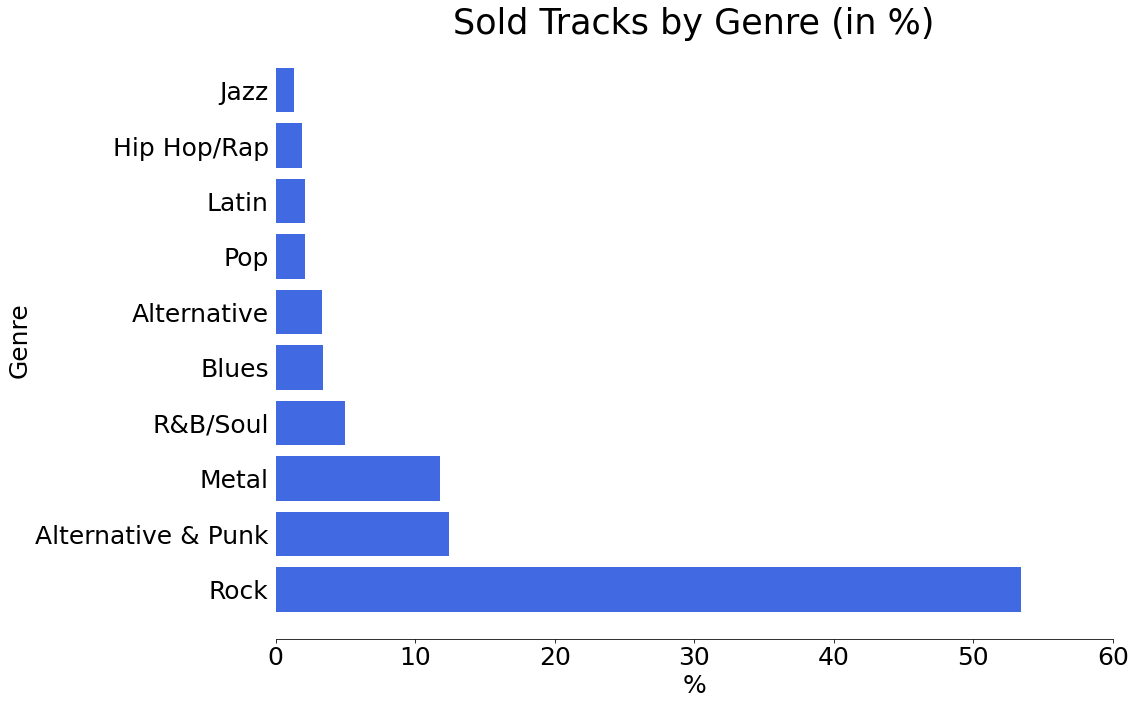

In [23]:
# Plotting sold tracks by genre in %
fig, ax = plt.subplots(figsize=(15,11))
list1 = df["percentage_sold"].tolist()
genre = df["genre"].tolist()
y=np.arange(len(genre))
ax.barh(y, list1, color='royalblue')
ax.set_title("Sold Tracks by Genre (in %)", fontsize=35)
ax.set_yticks(y)
ax.set_yticklabels(genre)
ax.set_ylabel("Genre", fontsize=25)
ax.set_xlabel("%", fontsize=25)
ax.set_xlim(0,60)
ax.tick_params(axis="both", 
               labelsize=25, 
               left = False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)


The most popular genres in the USA are **Rock**, **Alternative & Punk**, and **Metal**. Based on the rank of genres, we will recommend to purchase Red Tone (**Punk rank2**), Meteor and the Girls (**Pop rank7**), and Slim Jim Bites (**Blues rank5**). However, we will also suggest to try to add new **Rock** tracks into store since the history shows that more than 50% of sales are **Rock** genre.  

## Analyzing Employee Sales Performance

In [115]:
query = """ 
WITH customer_support_rep_sales AS(
SELECT
    i.customer_id,
    c.support_rep_id,
    SUM(i.total) total,
    COUNT(i.customer_id) customers
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
GROUP by 2
)

SELECT
     em.first_name || " " || em.last_name empolyee_name,
     em.hire_date,
     em.title,
     SUM(csrs.total) total,
     ROUND(csrs.total * 100.0 / (SELECT SUM(total) FROM customer_support_rep_sales),1) pct_sales,
     csrs.customers,
     ROUND(csrs.customers * 100.0 / (SELECT SUM(customers) FROM customer_support_rep_sales),1) pct_customers
FROM customer_support_rep_sales csrs
INNER JOIN employee em ON em.employee_id = csrs.support_rep_id
GROUP by 1
""" 

df = pd.read_sql_query(query, conn) 
df

,empolyee_name,hire_date,title,total,pct_sales,customers,pct_customers
0,Jane Peacock,2017-04-01 00:00:00,Sales Support Agent,1731.51,36.8,212,34.5
1,Margaret Park,2017-05-03 00:00:00,Sales Support Agent,1584.00,33.6,214,34.9
2,Steve Johnson,2017-10-17 00:00:00,Sales Support Agent,1393.92,29.6,188,30.6


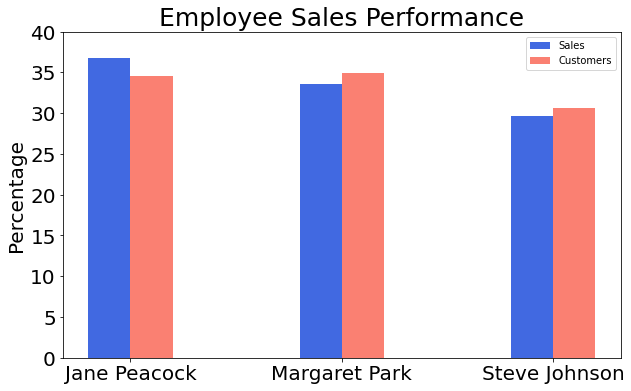

In [116]:
fig, ax = plt.subplots(figsize=(10,6))
list1 = df["pct_sales"].tolist()
list2 = df["pct_customers"].tolist()
name = df["empolyee_name"].tolist()
x=np.arange(len(name))
ax.bar(x-0.1, list1, width = 0.2, color='royalblue', label = 'Sales')
ax.bar(x+0.1, list2, width = 0.2, color='salmon', label = 'Customers')

ax.set_title("Employee Sales Performance", fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(name)
ax.set_ylabel("Percentage", fontsize=20)
#ax.set_xlabel("Employee", fontsize=25)
ax.set_ylim(0,40)
ax.tick_params(axis="both", 
               labelsize=20)
ax.legend(loc=0)

Base on the number of total sale, there is a ~20% difference between the top (Jane) and the bottom (Steve). However, their duty durations (`hire_date`) are also different. Jane works at this company 6 months ealier than Steve. 

## Analyzing Sales by Country

We will analyze the sales data for customers from each different country. Several factors will be indicated including number of customers, percentage of the customers, total sales, percentage of sales, and average sale per customer. Since there are several countries with only one customer, we will group these customers as "Other" in our analysis. 

In [117]:
query = """ 
WITH classify_country AS (  
SELECT
   CASE
      WHEN (
           SELECT count(*)
           FROM customer
           WHERE country = c.country
           ) = 1 THEN "Other"
           ELSE c.country
      END AS country,
  COUNT(DISTINCT c.customer_id) customers,
  SUM(i.total) total
  FROM invoice i
  INNER JOIN customer c ON c.customer_id = i.customer_id
  group by 1
)

SELECT
   country,
   customers,
   ROUND(customers * 100.0 / (SELECT SUM(customers) FROM classify_country), 1) pct_customer,
   total,
   ROUND(total * 100.0 / (SELECT SUM(total) FROM classify_country), 1) pct_sales,
   ROUND(total / customers, 1) sale_per_customer
FROM classify_country cc
ORDER by total DESC 
""" 
df = pd.read_sql_query(query, conn) 
df

,country,customers,pct_customer,total,pct_sales,sale_per_customer
0,Other,15,25.4,1094.94,23.2,73.0
1,USA,13,22.0,1040.49,22.1,80.0
2,Canada,8,13.6,535.59,11.4,66.9
3,Brazil,5,8.5,427.68,9.1,85.5
4,France,5,8.5,389.07,8.3,77.8
5,Germany,4,6.8,334.62,7.1,83.7
6,Czech Republic,2,3.4,273.24,5.8,136.6
7,United Kingdom,3,5.1,245.52,5.2,81.8
8,Portugal,2,3.4,185.13,3.9,92.6
9,India,2,3.4,183.15,3.9,91.6


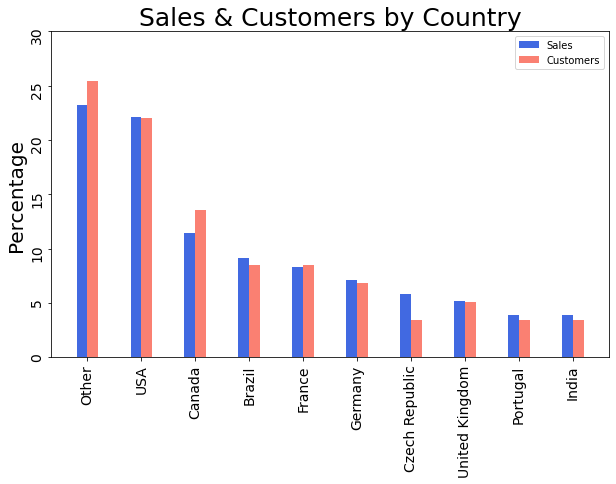

In [119]:
fig, ax = plt.subplots(figsize=(10,6))
list1 = df["pct_sales"].tolist()
list2 = df["pct_customer"].tolist()
name = df["country"].tolist()
x=np.arange(len(name))
ax.bar(x-0.1, list1, width = 0.2, color='royalblue', label = 'Sales')
ax.bar(x+0.1, list2, width = 0.2, color='salmon', label = 'Customers')

ax.set_title("Sales & Customers by Country", fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(name)
ax.set_ylabel("Percentage", fontsize=20)
#ax.set_xlabel("Employee", fontsize=25)
ax.set_ylim(0,30)
ax.tick_params(axis="both", 
               labelsize=14,
               rotation=90)
ax.legend(loc=0)

The sales are dominated by **USA**. Although `Other` has the highest percentage of sales and number of customers, it's a combination of many countries. It's worth to mention that **Czech Republic**, **Portugal**, and **India** have small amount of customers with fairly high average value of sales per customer. It's a encouraging result but we need to keep in mind that the sample size of these countries are small, there might be some bias. Still, we will recommend to explore the market in these high-potential countries.  

## Albums vs Individual Tracks
The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.



  category  num_invoices  pct_category
0    Album           114          18.6
1    Track           500          81.4


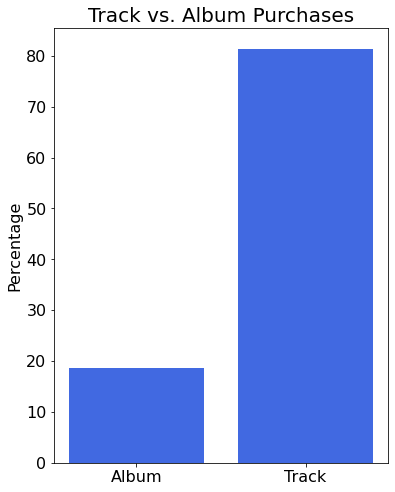

In [153]:
query = """
WITH invoice_al AS (
                    SELECT 
                       il.invoice_id,                                         
                       t.album_id album_id
                    FROM invoice_line il
                    LEFT JOIN track t ON t.track_id = il.track_id
                    GROUP BY 1
                    ),
                    
     classify_album_track AS (
                     SELECT ia.*,
                        CASE 
                        WHEN (
                          SELECT t.track_id
                          FROM track t
                          WHERE t.album_id = ia.album_id
                         
                          EXCEPT
                         
                          SELECT il.track_id
                          FROM invoice_line il 
                          WHERE il.invoice_id = ia.invoice_id ) IS NULL
                          
                         AND (
                         
                          SELECT il.track_id
                          FROM invoice_line il 
                          WHERE il.invoice_id = ia.invoice_id 
                          
                          EXCEPT
                          
                          SELECT t.track_id
                          FROM track t
                          WHERE t.album_id = ia.album_id ) IS NULL
                          
                        THEN "Album"
                        ELSE "Track"
                        
                        END AS category
                     
                     FROM invoice_al ia
                    )

SELECT category,
       COUNT(*) num_invoices,
       ROUND(COUNT(*) *100.0 / (SELECT COUNT(*) FROM classify_album_track), 1) pct_category
FROM classify_album_track 
GROUP by 1
  """ 
df = pd.read_sql_query(query, conn) 
print(df)                        

category = df['category'].tolist()
num_invoice = df['num_invoices'].tolist()
pct_category = df['pct_category'].tolist()

fig, ax = plt.subplots(figsize=(6,8))
x=np.arange(len(category))
ax.bar(x, pct_category, color='royalblue')
ax.set_xticks(x)
ax.set_xticklabels(category)
ax.set_ylabel("Percentage", fontsize=16)
ax.set_title("Track vs. Album Purchases", fontsize=20)
ax.tick_params(axis="both", labelsize=16)

It appears that customers are more inclined to purchase single tracks than to purchase an entire album. In light of this result, we will suggest that the department of management change their purchasing strategy by purchasing only the most popular tracks from each album from record companies, instead of purchasing every track from the album.

## Conclusions

The purpose of this project was to analyze a modified version of the Chinook database to find answers to our business questions. We have identified the following elements and suggestions that can be used to maximize total revenue:

* Based on the genre popularity ratings in the United States, it is recommended that the following 3 albums be purchased and advertised in the US: **Red Tone** (Punk), **Slim Jim Bites** (Blues), and **Meteor and the Girls** (Pop).

* **USA** is the major market among all the countries in terms of both the total sales and the number of customers. We also suggest to explore the market in these potential countries: **Czech Republic**, **Portugal**, and **India** by collecting more data and launch some mini campaign. 

* Customers are more inclined to purchase **single tracks** than to purchase an entire album. we will suggest that the department of management to only purchase the most popular tracks from each album from record companies.
